## Predicting Crashes in Financial Markets - Linear Regression
- Datasets: 'niftyIT', 'niftyAuto', 'niftybank', 'niftyInfra', 'niftymetal'
- Model: Linear Regression
- Response variable: Crash within 1 / 3 / 6 months (0: no, 1:yes)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
os.chdir('D:\Major Project\Predicting-Stock-Market-Crashes\models')
from prepare_data import DataLoader
from evaluate_results import EvaluateResults

In [2]:
# -------------------- Data preparation -------------------- #
os.chdir('D:\Major Project\Predicting-Stock-Market-Crashes\indiandata')
datasets_original = ['niftyIT.csv', 'niftyauto.csv', 'niftybank.csv','niftyInfra.csv', 'niftymetal.csv']
dataset_names = ['niftyIT', 'niftyAuto', 'niftybank', 'niftyInfra', 'niftymetal']


# specify drawdown thresholds for crashes (determined in exploration.ipynb):
# crashes according to Jacobsson:
crash_thresholds = [-0.104603, -0.106839, -0.106803, -0.106195, -0.126447]
# crashes according to Sornette:
# crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264]
months = [1, 3, 6]   # <-- predict if crash n months ahead (use: 1, 3 or 6)
data = DataLoader(datasets_original, dataset_names)
datasets_revised, crashes = data.get_data_revised(crash_thresholds)
dfs_x, dfs_y = data.get_dfs_xy(months=months)

In [3]:
# -------------------- Train Linear Regression -------------------- #
model_name = 'Linear Regression'
test_data = 'niftymetal'
month_prediction = 3
index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x_training = list(dfs_x)
dfs_x_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)
y_train_all, y_val_all = [], []
y_pred_train_all, y_pred_val_all = [], []
for val_data in training_set_names:
    x_train, y_train, x_val, y_val = data.get_train_test(dfs_x_training, dfs_y_training, \
            training_set_names, test_data=val_data)
    y_train, y_val = y_train[:, index_month].astype(int), y_val[:, index_month].astype(int)
    y_train_all.append(y_train)
    y_val_all.append(y_val)
    print('Train ' + str(model_name) + ' - validation data: ' + str(val_data))
    lm = linear_model.LinearRegression()
    model = lm.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_train_all.append(y_pred_train)
    y_pred_val = model.predict(x_val)
    y_pred_val_all.append(y_pred_val)

Train Linear Regression - validation data: niftyIT
Train Linear Regression - validation data: niftyAuto
Train Linear Regression - validation data: niftybank
Train Linear Regression - validation data: niftyInfra


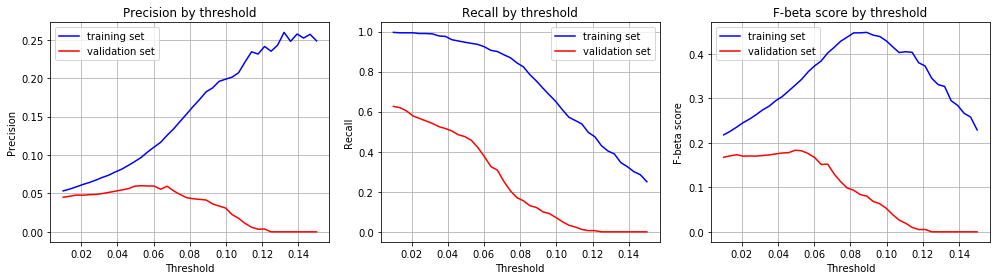

In [4]:
# -------------------- Find best threshold -------------------- #
beta = 2
rcParams['figure.figsize'] = 14, 4
eval_ = EvaluateResults(y_train_all, y_val_all, y_pred_train_all, y_pred_val_all, model_name,\
            test_data)
eval_.find_threshold(beta=beta, threshold_min=0.01, threshold_max=0.15, resolution=40)

In [5]:
# -------------------- Evaluate results -------------------- #
threshold = 0.075
beta = 2
print(model_name)
print('\n')
print('Predict crash in:            ' + str(month_prediction) + ' months')
print('Threshold for positives:     ' + str(threshold))
print('Number of features:          ' + str(dfs_x[0].shape[1]))
print('Number of rows for training: ' + str(len(y_pred_train_all[0]) + len(y_pred_val_all[0])))
print('\n')
eval_.training_results(threshold, training_set_names, beta=beta)

Linear Regression


Predict crash in:            3 months
Threshold for positives:     0.075
Number of features:          16
Number of rows for training: 4798


Results for each train/val split:
                       niftyIT  niftyAuto  niftybank  niftyInfra
positive actual train     0.03       0.03       0.04        0.02
positive pred train       0.25       0.20       0.31        0.10
precision train           0.12       0.12       0.13        0.20
recall train              0.90       0.76       0.94        0.88
accuracy_train            0.78       0.82       0.73        0.92
score_fbeta train         0.40       0.37       0.42        0.52
positive actual val       0.03       0.04       0.00        0.07
positive pred val         0.20       0.21       0.39        0.08
precision val             0.03       0.09       0.00        0.07
recall val                0.18       0.52       0.00        0.09
accuracy val              0.78       0.79       0.61        0.87
score fbeta val          

In [6]:
# -------------------- Test model -------------------- #
x_train, y_train, x_test, y_test = data.get_train_test(dfs_x, dfs_y, dataset_names, test_data)
y_train, y_test = y_train[:, index_month].astype(int), y_test[:, index_month].astype(int)
lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
y_pred_test = model.predict(x_test)
y_pred_test_bin = eval_.test_results(y_test, y_pred_test, threshold, beta=beta)

Test results (test set: niftybank):
Positive test cases actual:         0.04
Positive test cases predicted:      0.18
Precision test (model/random):      0.0 / 0.04
Recall test (model/random):         0.0 / 0.18
Accuracy test (model/random):       0.77 / 0.79
Score test fbeta:                   0.0 / 0.11


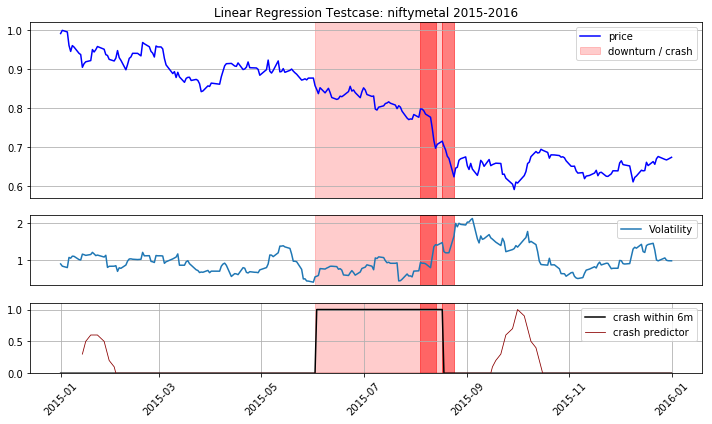

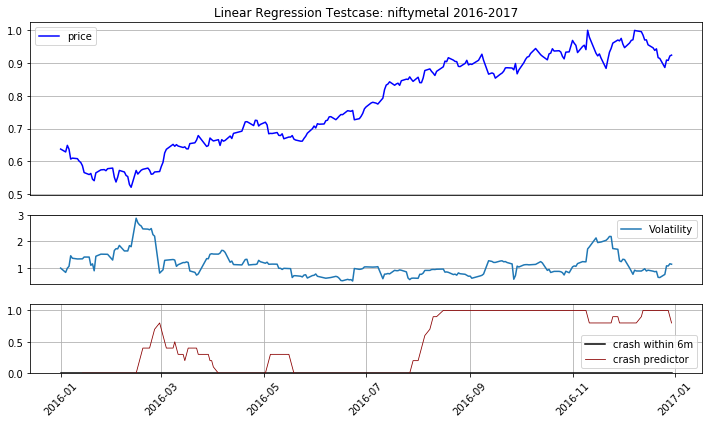

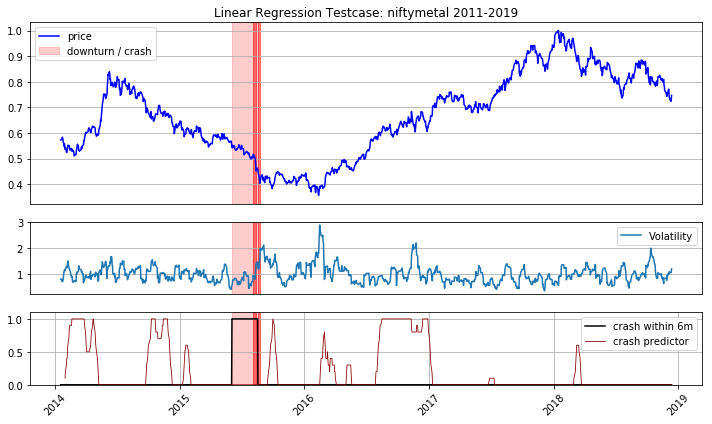

In [7]:
# -------------------- Plot test results -------------------- #
df = datasets_revised[index_test].reindex(dfs_x[index_test].index)
df['y'] = y_test
df['y_pred'] = y_pred_test_bin
c = crashes[index_test]
t_start = [ '2015-01-01','2016-01-01','2011-03-01']
t_end = [ '2016-01-01','2017-01-01','2019-03-01']
rcParams['figure.figsize'] = 10, 6
eval_.plot_test_results(df, c, t_start, t_end)

In [8]:
# -------------------- Current prediction niftymetal -------------------- #
# train on all available data:
x_train, y_train, _, _ = data.get_train_test(dfs_x, dfs_y, dataset_names, test_data=None)
thresholds = [0.05, 0.07, 0.07] # <-- determined by eval model for each prediction
dataset_original = ['niftymetal.csv']
dataset_name = ['niftymetal']
crash_threshold = [-0.0936]
data_new = DataLoader(dataset_original, dataset_name)
dataset_revised, crashes = data_new.get_data_revised(crash_threshold)
dfs_x_new, dfs_y_new = data_new.get_dfs_xy_predict(months=months)
x_new, _, _, _ = data_new.get_train_test(dfs_x_new, dfs_y_new, dataset_name, test_data=None)

for index_month in range(len(months)):
    y_train_ = y_train[:, index_month].astype(int)
    lm = linear_model.LinearRegression()
    model = lm.fit(x_train, y_train_)
    y_pred_new = model.predict(x_new)
    y_pred_new_bin = y_pred_new > thresholds[index_month]
    y_pred_new_bin = y_pred_new_bin.astype(int)
    current_pred = np.dot(np.linspace(0,1,42)/sum(np.linspace(0,1,42)), y_pred_new_bin[-42:])
    print(str(model_name) + ' prediction of a crash within ' + str(months[index_month]) \
          + ' months: ' + str(np.round(current_pred, 2)))

Linear Regression prediction of a crash within 1 months: 0.13
Linear Regression prediction of a crash within 3 months: 0.06
Linear Regression prediction of a crash within 6 months: 0.72
